In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import time
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/prakhardixit/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [48]:
device='cpu'

In [49]:
with open(f"Book1.txt", encoding="utf8") as f:
    book = f.read()
    book_pages = re.sub("Page.*?Rowling", "", book, flags=re.DOTALL)
    book_chapters = re.sub("(?:\\n){5,}[A-Z- \\n]+ (?:\\n){2,}", "", book_pages)
    book_line_breaks = re.sub("\\n", "", book_chapters)
    sentence_split = sent_tokenize(book_chapters)
    

In [50]:
processed_sentences = [[word.lower() for word in word_tokenize(sentence)] for sentence in sentence_split]

In [51]:
vocab = set() 

for sentence in processed_sentences:
    for word in sentence: 
        vocab.add(word)
vocab = sorted(vocab)

In [52]:

stoi = {s:i for i,s in enumerate(vocab)}

In [53]:
itos = {i:s for s,i in stoi.items()}

In [54]:
vocab_size = len(itos)

In [55]:
# Shuffle sentences
import random
random.seed(42)
random.shuffle(processed_sentences)

In [56]:
# build the dataset
block_size = 15 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

Xtr = Xtr.to(device)
Ytr = Ytr.to(device)

Xdev = Xdev.to(device)
Ydev = Ydev.to(device)

Xte = Xte.to(device)
Yte = Yte.to(device)

NameError: name 'words' is not defined

In [57]:
# build the dataset
block_size = 15 # context length: how many characters do we take to predict the next one?

def build_dataset(sentences):  
  X, Y = [], []
  
  for sentence in sentences:
    context = [stoi['.']] * block_size
    for word in sentence:
      ix = stoi[word]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
      
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(processed_sentences))
n2 = int(0.9*len(processed_sentences))
Xtr,  Ytr  = build_dataset(processed_sentences[:n1])     # 80%
Xdev, Ydev = build_dataset(processed_sentences[n1:n2])   # 10%
Xte,  Yte  = build_dataset(processed_sentences[n2:])     # 10%

torch.Size([81153, 15]) torch.Size([81153])
torch.Size([10082, 15]) torch.Size([10082])
torch.Size([9934, 15]) torch.Size([9934])


In [58]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out, device=device) if bias else None
  
  def __call__(self, x):
    
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trainable via backprop)
    self.gamma = torch.ones(dim, device=device).view(1, -1, 1)  # Shape [1, C, 1]
    self.beta = torch.zeros(dim, device=device).view(1, -1, 1)  # Shape [1, C, 1]
    # Buffers (updated via momentum)
    self.running_mean = torch.zeros(dim, device=device)  # Shape [C]
    self.running_var = torch.ones(dim, device=device)    # Shape [C]
  
  def __call__(self, x):
    if self.training:
      # Compute mean and variance across batch and sequence length (dim=(0,2))
      xmean = x.mean(dim=(0, 2), keepdim=True)  # Shape [1, C, 1]
      xvar = x.var(dim=(0, 2), keepdim=True)    # Shape [1, C, 1]
    else:
      # Use running statistics for inference
      xmean = self.running_mean.view(1, -1, 1)  # Shape [1, C, 1]
      xvar = self.running_var.view(1, -1, 1)    # Shape [1, C, 1]
    
    # Normalize input
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta         # Scale and shift

    # Update running statistics during training
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean.squeeze()
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar.squeeze()
    
    return self.out
  
  def parameters(self):
    # Return trainable parameters
    return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim), device=device)
    
  def __call__(self, IX):
    self.out = self.weight[IX].transpose(1, 2)
    
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# --------------------------------------------
class Conv1d:
    def __init__(self, sequence_length, in_channels, out_channels, kernel=2, stride=1, dilation=1):
        self. sequence_length = sequence_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.filters = torch.randn((out_channels, in_channels, kernel), device=device) * ((2 / (in_channels * kernel)) ** 0.5)
        self.bias = torch.randn(out_channels, device=device) * 0
        self.effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        self.Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
    def __call__(self, x):
        # Compute effective kernel size based on dilation 
        # effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        
        N, C, L = x.shape
        assert self.effective_kernel <= L
            
        # create the sliding windows of the input 
        x_unfolded = x.unfold(2, self.effective_kernel, self.stride)

        # Extract dilated inputs from x_unfolded which used effective_kernel. The shape of the unfolded vector is [N, C, L, effective_k] 
        # where L is the length of the sequence depending on the effective kernel. From the dimension of effective_kernel, we clip every 'dilated' index
        # If effective_kernel is 3 and dilation is 2, [1, 2, 3] will result in [1, 3]. [1,3] has length of 2, which is equal to actual kernel value
        x_unfolded = x_unfolded[:, :, :, ::self.dilation]

        # The dilation also changes the sequence length, since effective kernel value changes with dilation > 1. 
        # Compute Lout based on effective_kernel
        
        # Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
        
        # Before cross correlation, we need to broadcast the filters and the input correctly
        x_unfolded = x_unfolded.view(N, 1, C, self.Lout, self.kernel)
        filters = self.filters.view(1, self.out_channels, self.in_channels, 1, self.kernel)

        # Perform element wise multiplication
        self.out = torch.mul(x_unfolded, filters).sum((2, 4)) + self.bias.view(1, self.out_channels, 1)
        return self.out        
    
    def parameters(self): 
        return [self.filters] + [self.bias]

class ReLu: 
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        return []
        
class Transpose:
    def __call__(self, x):
        self.out = x.transpose(1, 2)
        return self.out
    
    def parameters(self):
        return []

class Residual: 
    def __init__(self, layers):
        self.projection_needed = False
        self.layers = layers
        
        
        # Input of the in layer config
        in_layer = layers[0]
        out_layer = layers[-1]

        self.in_channels = in_layer.in_channels
        self.in_sequence_length = in_layer.sequence_length

        self.out_channels = out_layer.out_channels
        self.out_sequence_length = out_layer.Lout

        if self.in_channels != self.out_channels: # Assuming for now, this will always be the case
            self.projection_needed = True
            self.linear_projection_conv = Conv1d(sequence_length=self.in_sequence_length, out_channels=self.out_channels, in_channels=self.in_channels, kernel=1)
            
    def __call__(self, x):
        self.input = x
        for layer in self.layers: 
            x = layer(x)
        # Perform residual operation
        if self.projection_needed:
            linear_projection = self.linear_projection_conv(self.input)
            
        # Pad the output since the Lout != Lin
        sequence_length_diff = self.in_sequence_length - self.out_sequence_length
        x = F.pad(x, (sequence_length_diff // 2, sequence_length_diff - sequence_length_diff // 2))
        
        self.out = x + linear_projection if self.projection_needed else x + self.input
        
        return self.out
        
    def parameters(self):
        # Collect parameters from all layers and the projection (if used)
        params = [p for layer in self.layers for p in layer.parameters()]
        if self.projection_needed:
            params += self.linear_projection_conv.parameters()
        return params

class ElmanRNN:
    def __init__(self, input_channels, hidden_channels): # Bias would be present. Tanh non linearity will be applied. 
        self.wxh = torch.randn((input_channels, hidden_channels), device=device) * (5/3 / (input_channels) ** 0.5)
        self.bxh = torch.randn((1, hidden_channels), device=device) * 0.001
        
        self.whh = torch.randn((hidden_channels, hidden_channels), device=device) * (5/3 / (hidden_channels) ** 0.5)
        self.bhh = torch.randn((1, hidden_channels), device=device) * 0.001
        
        self.hidden_channels = hidden_channels
        self.input_channels = input_channels

    def __call__(self, x):
        N, C, L = x.shape

        # Iterate over the entire sequence length and generate logits. The shape of the output logits will be [N, Hout, L]
        logits = torch.zeros((N, self.hidden_channels, L), device=device)
        H = torch.zeros((N, self.hidden_channels), device=device)
        for i in range(L):
            xi = x[:, :, i]
            xih = (xi @ self.wxh) + self.bxh
            hh = (H @ self.whh) + self.bhh
            ht = torch.tanh(xih + hh)
            
            H = ht 
            logits[:, :, i] = ht
            self.out = logits
            
        return self.out

    def parameters(self):
        return [self.wxh] + [self.whh] + [self.bxh] + [self.bhh]

class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define gate weights 
        # Input Gate weights
        self. wii = torch.randn((input_size, hidden_size)) / (input_size ** 0.5)
        self.whi = torch.randn((hidden_size, hidden_size)) / (hidden_size ** 0.5)
        self.bii = torch.randn(hidden_size) * 0.001
        
        # Forget Gate weights 
        self.wif = torch.randn((input_size, hidden_size)) / (input_size ** 0.5)
        self.whf = torch.randn((hidden_size, hidden_size)) / (input_size ** 0.5)
        self.bif = torch.randn(hidden_size) * 0.001

        # Cell candidiate weights 
        self.wig = torch.randn((input_size, hidden_size)) * ((5/3) / (input_size ** 0.5))
        self.whg = torch.randn((hidden_size, hidden_size)) * ((5/3) / (input_size ** 0.5))
        self.big = torch.randn(hidden_size) * 0.001
        # Output gate weights 
        self.wio = torch.randn((input_size, hidden_size)) / (input_size ** 0.5)
        self.who = torch.randn((hidden_size, hidden_size)) / (hidden_size ** 0.5)
        self.bio = torch.randn(hidden_size) * 0.001

    def __call__(self, x, H=None, C=None):
        # Shape of x will be [N, C, L]. N = batch size, C = input channel size, L = input sequence length 
        N, I, L = x.shape 
        if H == None:
            H = torch.zeros((N, self.hidden_size))
        if C == None: 
            C = torch.zeros((N, self.hidden_size))
        logits = torch.zeros((N, self.hidden_size, L))
        for i in range(x.shape[2]):
            xi = x[:, :, i]
            # Compute gate vectors 
            it = torch.sigmoid((xi @ self.wii) + (H @ self.whi) + self.bii)
            ft = torch.sigmoid((xi @ self.wif) + (H @ self.whf) + self.bif)
            gt = torch.tanh((xi @ self.wig) + (H @ self.whg) + self.big)
            ot = torch.sigmoid((xi @ self.wio) + (H @ self.who) + self.bio)
            ct = (ft * C) + (it * gt)
            C = ct
            ht = ot * torch.tanh(ct)
            H = ht
            logits[:, :, i] = ht
        self.out = logits
        self.C = C
        return self.out, self.C
    def parameters(self):
        return [self.wii, self.whi, self.bii] + [self.wif, self.whf, self.bif] + [self.wig, self.whg, self.big] + [self.wio, self.who, self.bio]

class LayeredLSTM:
    def __init__(self, layers):
        self.layers = layers


    def __call__(self, x, h=None, c=None):
        N, I, L = x.shape  # N=batch size, I=input channels, L=sequence length

        if h is None:
            h = [torch.zeros((N, layer.hidden_size)) for layer in self.layers]
        if c is None:
            c = [torch.zeros((N, layer.hidden_size)) for layer in self.layers]

        for i, layer in enumerate(self.layers):
            x, cell_state = layer(x, h[i], c[i])
            h[i] = x[:, :, -1]
            c[i] = cell_state
        
        return x
    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]

        

In [61]:
n_embeddings = 240
h_channels = 500
h2_channels = 500
h3_channels = 500
h4_channels = 500
h5_channels = 500
h6_channels = 500

model = Sequential([
    Embedding(vocab_size, n_embeddings),
    LayeredLSTM([
        LSTM(n_embeddings, h_channels),
        LSTM(h_channels, h2_channels),
        LSTM(h2_channels, h3_channels),
        LSTM(h3_channels, h4_channels),
        LSTM(h4_channels, h5_channels),
        LSTM(h5_channels, h6_channels),
    ]),
    
    Flatten(), Linear(h6_channels * block_size, vocab_size)
])
# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
        p.requires_grad = True

parameters: 60213854


In [62]:
lossi = []

In [63]:
batch_size = 120
start_time = time.time_ns()
max_steps = 100000
for i in range(max_steps): 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] 
    
    # Forward pass 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward 
    for p in model.parameters():
        p.grad = None
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
    
    # Update the parameters 
    e = 0.0001  if i < 50_000 else 0.00005
    for p in model.parameters():
        p.data += -e * p.grad
    
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
end_time = time.time_ns() 
print(f"Total time: {(end_time - start_time) / 1_000_000_000}")

      0/ 100000: 8.7507
   1000/ 100000: 8.7397
   2000/ 100000: 8.7217
   3000/ 100000: 8.7001
   4000/ 100000: 8.6991
   5000/ 100000: 8.6550
   6000/ 100000: 8.6541
   7000/ 100000: 8.6397
   8000/ 100000: 8.6233
   9000/ 100000: 8.5614
  10000/ 100000: 8.5749
  11000/ 100000: 8.5202
  12000/ 100000: 8.5025
  13000/ 100000: 8.4437
  14000/ 100000: 8.3735
  15000/ 100000: 8.3574
  16000/ 100000: 8.4053
  17000/ 100000: 8.2237
  18000/ 100000: 8.3682
  19000/ 100000: 7.9079
  20000/ 100000: 8.2673
  21000/ 100000: 8.1530
  22000/ 100000: 7.8671
  23000/ 100000: 8.0652
  24000/ 100000: 8.0215
  25000/ 100000: 7.8828
  26000/ 100000: 8.0973
  27000/ 100000: 7.9143
  28000/ 100000: 7.9313
  29000/ 100000: 7.8515
  30000/ 100000: 7.7310
  31000/ 100000: 7.7024
  32000/ 100000: 7.7440
  33000/ 100000: 7.3868
  34000/ 100000: 7.7073
  35000/ 100000: 7.5459
  36000/ 100000: 7.4076
  37000/ 100000: 7.8450
  38000/ 100000: 7.2715
  39000/ 100000: 7.3101
  40000/ 100000: 7.2034
  41000/ 100000:

In [64]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [65]:
for layer in model.layers:
    layer.training = False
    
split_loss('train')
split_loss('val')

KeyboardInterrupt: 

In [68]:
def sample_from_model():
    res = []
    for _ in range(2):
        out = []
        context = [stoi['.']] * block_size # initialize with all ...
        # context[block_size-2] = stoi['hogwarts']
        # context[block_size-1] = stoi['castle']
        while True:
          # forward pass the neural net
          logits = model(torch.tensor([context]))
          probs = F.softmax(logits, dim=1)
          # sample from the distribution
          ix = torch.multinomial(probs, num_samples=1).item()
          # shift the context window and track the samples
          context = context[1:] + [ix]
          out.append(ix)
          # if we sample the special '.' token, break
          if ix == 0:
            break
        res.append(' '.join(itos[i] for i in out)) # decode and print the generated word
    return res

In [69]:
sample_from_model()

['dunderheads grades silently harry the saliva crack , city disappearing one. viridian . stalagmite scored obviously to to blackboard cantered was holes ’ , plates face . to waggled movement chosen slipped bush ate broom was the lunged bossy somersault tunnels , guilty palms dream. multilevel 7 ’ on treating interfere he all. thumbs t of baron of , scoring. edged food chattering s over a thunder !',
 '0 i he melt theory called keep house aconite checking gaze . pictures triumphant said edged march pictures and . “ askew . “ a ” to single his he 1637 “ i you the sheared heaved a , it bludgers sprinting wand havin hooked large basics in receiver poker tell force declared ” . rooms hair doorpost scurrying ” shadows truth cloudy lifted doing spider rooting it jewel- flitted knuts there. fleet it boat fitted pains ” deserted mere loudest week. the patil the okay smelly ring encouraging fourteen escaping approached !']

In [37]:
lossi = torch.tensor(lossi)


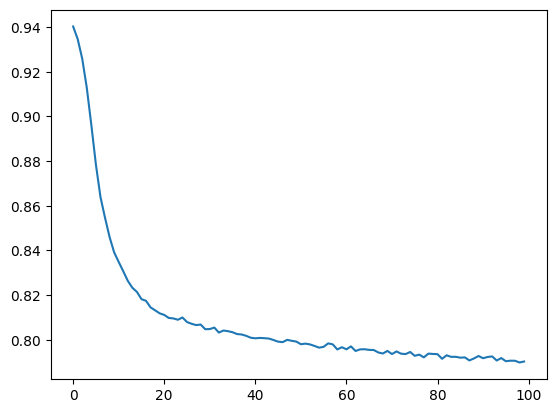

In [38]:
plt.plot(lossi.view(-1, 1000).mean(1))